# Social Network Analysis - Exercise Sheet 6)


### Knowledge Graphs

In this task, you will work with Knowledge graphs. In particular, you will use Wikidata to generate a data set. You will then analyze the data set and provide visualizations. You are free to choose what to analyze in this task.

#### Guidelines
* Submit your code zipped via [moodle](https://moodle.uni-kassel.de/course/view.php?id=18460) until 10.08.2025 23:55 MEZ
* Use the help pages from the WikiData website (https://www.wikidata.org) to learn how to retrieve data.

##### Exercise:
1. Use the Wikidata API to generate your own data set. The data set should consist of at least 30 entities.
2. Analyze the data set with either:
    - Methods you implemented in the previous exercises
    - New methods.
3. Provide visualizations for your analyses.

Make sure to add all code for the analyses as well as for creating the data set within the jupyter notebook. The data set should be created when the notebook is run.

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests

from networkx.algorithms import bipartite
from networkx.algorithms.clique import find_cliques as maximal_cliques

import numpy as np
from scipy.stats import entropy as entropy_fn

SEED = 42
LIMIT = 60
import random
random.seed(SEED)
np.random.seed(SEED)

from string import Template

## Scientists × Fields (Wikidata)

1. Grab a small **scientist ↔ field** sample from Wikidata.
2. Build a **bipartite graph** (`B`).
3. Reuse methods from earlier notebooks.
4. Project onto **scientists** and **fields** and compare.
5. Wrap up with a **summary table**.


## 1) Grab some data

In [15]:
endpoint = "https://query.wikidata.org/sparql"
query_tpl = Template("""
SELECT ?s ?sLabel ?f ?fLabel WHERE {
  ?s wdt:P106 wd:Q901 .
  ?s wdt:P101 ?f .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT $LIMIT
""")
query = query_tpl.substitute(LIMIT=LIMIT)
try:
    r = requests.get(
        endpoint,
        params={'query': query},
        headers={"Accept":"application/sparql-results+json","User-Agent":"exercise-6/1.0"},
        timeout=20,
    )
    r.raise_for_status()
    data = r.json()
    rows = []
    for b in data["results"]["bindings"]:
        rows.append({
            "s": b["s"]["value"].split("/")[-1],
            "s_label": b["sLabel"]["value"],
            "f": b["f"]["value"].split("/")[-1],
            "f_label": b["fLabel"]["value"],
        })
    df = pd.DataFrame(rows).drop_duplicates()
except Exception:
    df = pd.DataFrame({
        "s": ["Q7186","Q937","Q16977","Q7259","Q7251","Q173746"],
        "s_label": ["Marie Curie","Albert Einstein","Niels Bohr","Ada Lovelace","Alan Turing","Katherine Johnson"],
        "f": ["Q413","Q413","Q413","Q21198","Q21198","Q395"],
        "f_label": ["Physics","Physics","Physics","Computer science","Computer science","Mathematics"],
    })
print(len(df), "rows")
df.head(8)


60 rows


,s,s_label,f,f_label
0,Q307,Galileo Galilei,Q333,astronomy
1,Q307,Galileo Galilei,Q395,mathematics
2,Q307,Galileo Galilei,Q413,physics
3,Q307,Galileo Galilei,Q5891,philosophy
4,Q307,Galileo Galilei,Q41217,mechanics
5,Q464,Philipp Ludwig von Seidel,Q333,astronomy
6,Q464,Philipp Ludwig von Seidel,Q395,mathematics
7,Q464,Philipp Ludwig von Seidel,Q4213,telescope


## 2) Build bipartite graph `B`

In [16]:
B = nx.Graph()
for _, r in df.iterrows():
    B.add_node(r["s"], bipartite=0, type="scientist", label=r["s_label"])
    B.add_node(r["f"], bipartite=1, type="field", label=r["f_label"])
    B.add_edge(r["s"], r["f"])
U = [n for n, d in B.nodes(data=True) if d["bipartite"]==0]
V = [n for n, d in B.nodes(data=True) if d["bipartite"]==1]
print("|V|=", B.number_of_nodes(), "|E|=", B.number_of_edges(), "|U|=", len(U), "|V|=", len(V))

|V|= 60 |E|= 60 |U|= 9 |V|= 51


## 3) Visual

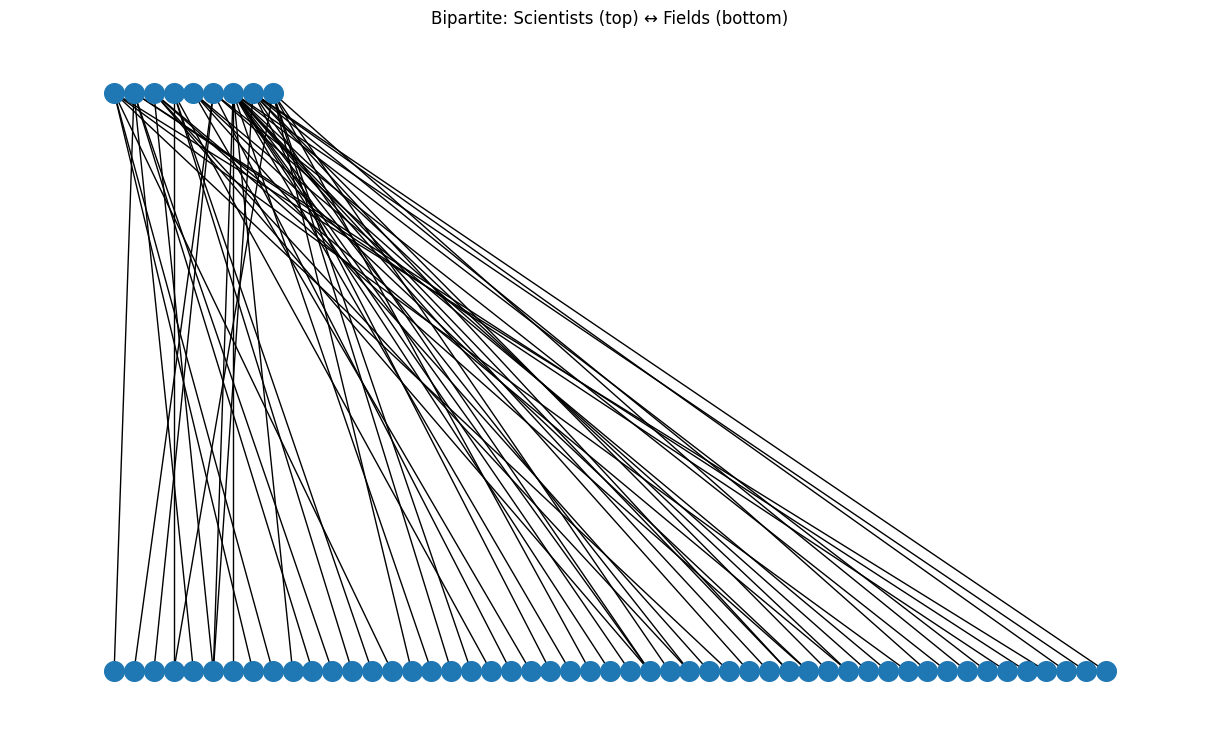

In [17]:
def _label(n):
    return B.nodes[n].get('label', str(n))
U_sorted = sorted(U, key=_label)
V_sorted = sorted(V, key=_label)
pos = {}
pos.update((n, (i, 1)) for i, n in enumerate(U_sorted))
pos.update((n, (i, 0)) for i, n in enumerate(V_sorted))
plt.figure(figsize=(12, 7))
nx.draw(B, pos, with_labels=False, node_size=200)
plt.title('Bipartite: Scientists (top) ↔ Fields (bottom)')
plt.show()


## 4) Methods from earlier notebooks

In [18]:
def analyize_distributions_bipartite_graph(G, distribution=None, attribute='bipartite'):
    # Separate by groups
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # define proper bin sizes
    t_max = max([G.degree(n) for n in t])
    t_bins = [-0.5 + i  for i in range(0,t_max+2)]
    b_max = max([G.degree(n) for n in b])
    b_bins = [-0.5 + i  for i in range(0,b_max+2)]

    # create the plots
    fig, ax = plt.subplots(1,2,figsize=(12,3))
    
    # reference histogram in red
    if distribution:
        ax[0].hist(distribution.rvs(size=5000),bins=t_bins, color='red', density=True)
    
    ax[0].hist([G.degree(node) for node in t], bins=t_bins, rwidth=0.9, density=True)
    ax[0].set_xlabel('Node Degree')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title("Histogram of top node degrees")
    ax[1].hist([G.degree(node) for node in b], bins=b_bins, rwidth=0.9, density=True)
    ax[1].set_xlabel('Node Degree')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title("Histogram of bottom node degrees")
    plt.show()
    return
    
def draw_bipartite_graph(G,attribute='bipartite', sort_top=True, sort_bottom=True):
    # Separate by group
    t = list(n for n,d in G.nodes(data=True) if d[attribute]==0)
    b = list(n for n,d in G.nodes(data=True) if d[attribute]==1)
    
    # create the color map
    color_map = []
    for node,d in G.nodes(data=True) :
        if d[attribute]==0:
            color_map.append('orange')
        else: color_map.append('lightgreen')  

    pos = {}
    # Update position for node from each group
    # sort the nodes by degree
    if sort_top:
        t = sorted(t, key=lambda node: G.degree(node),reverse=True)
    if sort_bottom:
        b = sorted(b, key=lambda node: G.degree(node),reverse=True)
    
    pos.update((node, (index, 2)) for index, node in enumerate(t))
    pos.update((node, (index, 1)) for index, node in enumerate(b))

    nx.draw(G, pos=pos, node_color = color_map, with_labels = True)
    plt.show()
    return

def Connected(G):
    # connectedness of G
    connected = nx.is_connected(G)
    return connected

def ASP(G):
    # average shortest path in G
    if Connected(G):
        ASP = nx.average_shortest_path_length(G)
        return ASP
    else:
        return float('inf')

def ALCC(G):
    # average clustering coefficient of G
    if Connected(G):
        ALCC = nx.average_clustering(G)
        return ALCC
    else:
        return -1
    
def NumNodes(G):
    # number of nodes of G
    return G.number_of_nodes()

def NumEdges(G):
    # number of edges of G
    return G.number_of_edges()

def Density(G):
    # density of G
    Density = nx.density(G)
    return Density

def ADeg(G):
    # average degree of G
    ADeg = sum(dict(G.degree()).values()) / G.number_of_nodes()
    return ADeg

def project_bipartite_graph(G, attribute='bipartite'):
    # computes the projections onto the top and bottom node sets of a bipartite graph

    # Separate top and bottom nodes based on bipartite attribute
    top_nodes = {n for n, d in G.nodes(data=True) if d[attribute] == 0}
    bottom_nodes = set(G) - top_nodes

    # Create projections
    top_graph = bipartite.projected_graph(G, top_nodes)
    bottom_graph = bipartite.projected_graph(G, bottom_nodes)
    
    return top_graph, bottom_graph

import random as rd
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

def floyd_warshall(G):
    
    nodes = list(G.nodes())
    n = len(nodes)
    dist = {u: {v: float('inf') for v in nodes} for u in nodes}
    
    for u in nodes:
        dist[u][u] = 0
    
    for u, v in G.edges():
        dist[u][v] = 1
        dist[v][u] = 1
    
    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dist[i][j] > dist[i][k] + dist[k][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
    
    return dist

def average_shortest_path(G):
    
    dist = floyd_warshall(G)
    total = 0
    count = 0
    
    for u in G.nodes():
        for v in G.nodes():
            
            if u != v and dist[u][v] != float('inf'):
                total += dist[u][v]
                count += 1
    
    ASP = total / count if count > 0 else 0
    return ASP

def average_local_clustering_coefficient(G):
    return nx.average_clustering(G)

def randomize_edges(G, n=100):
    
    p = 0.1
    nodes = list(G.nodes())
    new_G = nx.Graph()
    new_G.add_nodes_from(nodes)
    k = len(list(G.neighbors(nodes[0])))  # Assuming regular ring lattice
    
    for node in nodes:
        neighbors = sorted(G.neighbors(node))
        
        for neighbor in neighbors:
            
            if node < neighbor:  # Avoid duplicates
                if rd.random() < p:
                    
                    new_target = rd.choice(nodes)
                    
                    while new_target == node or new_G.has_edge(node, new_target):
                        new_target = rd.choice(nodes)
                        
                    new_G.add_edge(node, new_target)
                    
                else:
                    new_G.add_edge(node, neighbor)
    
    return new_G

from networkx.algorithms.community import modularity

def compute_modularity(G, clustering):
    
    return modularity(G, clustering)

def generate_high_modularity_clustering(G):
    
    cliques = list(nx.find_cliques(G))  # All maximal cliques
    cliques.sort(key=len, reverse=True)  # Prioritize larger cliques

    assigned = set()
    clusters = []

    for clique in cliques:
        cluster = set(clique) - assigned
        if cluster:
            clusters.append(cluster)
            assigned.update(cluster)

    # Assign any leftover unassigned nodes to singleton clusters
    for node in G.nodes():
        if node not in assigned:
            clusters.append({node})

    return clusters

import networkx as nx
import matplotlib.pyplot as plt

def k_core(G, k):
    
    return nx.k_core(G, k=k).nodes

def all_k_cores(G):
    
    data = []
    
    for k in range(max(dict(G.degree()).values())):
        core_size = len(k_core(G, k))
        if core_size > 0:
            data.append((k, core_size))

    x, y = zip(*data)

    # Scatter plot
    plt.scatter(x, y)
    plt.xlabel('K - core')
    plt.ylabel('Size')
    plt.title('Core number k against the size of that core')
    plt.show()

import networkx as nx
import matplotlib.pyplot as plt

def k_core(G, k):
    
    return nx.k_core(G, k=k).nodes

def all_k_cores(G):
    
    data = []
    
    for k in range(max(dict(G.degree()).values())):
        core_size = len(k_core(G, k))
        if core_size > 0:
            data.append((k, core_size))

    x, y = zip(*data)

    # Scatter plot
    plt.scatter(x, y)
    plt.xlabel('K - core')
    plt.ylabel('Size')
    plt.title('Core number k against the size of that core')
    plt.show()

import networkx as nx

def structurally_equivalent(G, node_i, node_j):
    
    return set(G.neighbors(node_i)) - {node_i} == set(G.neighbors(node_j)) - {node_j}

def is_equivalence_relation(G, relation):
    
    nodes = list(G.nodes())
    
    #reflexivity
    for node in nodes:
        
        if not relation(G, node, node):
            return False

    #symmetry
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            
            if relation(G, nodes[i], nodes[j]) != relation(G, nodes[j], nodes[i]):
                return False

    #tansitivity
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            for k in range(len(nodes)):
                
                if relation(G, nodes[i], nodes[j]) and relation(G, nodes[j], nodes[k]):
                    if not relation(G, nodes[i], nodes[k]):
                        return False
                        
    return True

def equivalence_classes(G, relation):
    
    nodes = set(G.nodes())
    classes = []
    visited = set()

    for u in nodes:
        
        if u in visited:
            continue
            
        eq_class = {u}
        
        for v in nodes:
            if v != u and relation(G, u, v):
                eq_class.add(v)
                
        visited.update(eq_class)
        classes.append(eq_class)

    return classes

def is_structural_equivalence(G, relation):

    nodes = set(G.nodes())
    
    if not is_equivalence_relation(G, relation):
        return False

    for u in nodes:
        for v in nodes:

            if relation(G, u, v) and not set(G.neighbors(u)) - {u} == set(G.neighbors(v)) - {v}:
                return False
        
    return True
    
def maximal_roles(G, relation):
    
    classes = equivalence_classes(G, relation)
    role_assignment = {}
    
    for role_id, eq_class in enumerate(classes, start=1):
        for node in eq_class:
            role_assignment[node] = role_id

    return role_assignment

G = nx.karate_club_graph()
maximal_roles(G, structurally_equivalent)

import networkx as nx

def structurally_equivalent(G, node_i, node_j):
    
    return set(G.neighbors(node_i)) - {node_i} == set(G.neighbors(node_j)) - {node_j}

def is_equivalence_relation(G, relation):
    
    nodes = list(G.nodes())
    
    #reflexivity
    for node in nodes:
        
        if not relation(G, node, node):
            return False

    #symmetry
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            
            if relation(G, nodes[i], nodes[j]) != relation(G, nodes[j], nodes[i]):
                return False

    #tansitivity
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            for k in range(len(nodes)):
                
                if relation(G, nodes[i], nodes[j]) and relation(G, nodes[j], nodes[k]):
                    if not relation(G, nodes[i], nodes[k]):
                        return False
                        
    return True

def equivalence_classes(G, relation):
    
    nodes = set(G.nodes())
    classes = []
    visited = set()

    for u in nodes:
        
        if u in visited:
            continue
            
        eq_class = {u}
        
        for v in nodes:
            if v != u and relation(G, u, v):
                eq_class.add(v)
                
        visited.update(eq_class)
        classes.append(eq_class)

    return classes

def is_structural_equivalence(G, relation):

    nodes = set(G.nodes())
    
    if not is_equivalence_relation(G, relation):
        return False

    for u in nodes:
        for v in nodes:

            if relation(G, u, v) and not set(G.neighbors(u)) - {u} == set(G.neighbors(v)) - {v}:
                return False
        
    return True
    
def maximal_roles(G, relation):
    
    classes = equivalence_classes(G, relation)
    role_assignment = {}
    
    for role_id, eq_class in enumerate(classes, start=1):
        for node in eq_class:
            role_assignment[node] = role_id

    return role_assignment

G = nx.karate_club_graph()
maximal_roles(G, structurally_equivalent)

def uniform_random_graph(num_graphs=10, number_nodes=100, edge_probability=0.1):

    uniform_graphs = [nx.erdos_renyi_graph(number_nodes, edge_probability) for _ in range(num_graphs)]
    return uniform_graphs

def non_uniform_random_graph(num_graphs=10, sizes=[50, 50], probs=[[0.1, 0.02], [0.02, 0.05]], seed=42):
    """SBM generator: Stochastic Block Model"""
    
    graphs = []
    rng = np.random.default_rng(seed)

    for _ in range(num_graphs):
        s = int(rng.integers(0, 1000000))  # convert numpy.int64 to Python int
        G = nx.stochastic_block_model(sizes, probs, seed=s)
        graphs.append(G)
        
    return graphs

def graph_density(G):
    
    return nx.density(G)

def graph_entropy(G):

    degrees = [d for _, d in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    prob_dist = counts / counts.sum()
    return entropy_fn(prob_dist) / np.log(2)

def uniform_random_graph(num_graphs=10, number_nodes=100, edge_probability=0.1):

    uniform_graphs = [nx.erdos_renyi_graph(number_nodes, edge_probability) for _ in range(num_graphs)]
    return uniform_graphs

def non_uniform_random_graph(num_graphs=10, sizes=[50, 50], probs=[[0.1, 0.02], [0.02, 0.05]], seed=42):
    """SBM generator: Stochastic Block Model"""
    
    graphs = []
    rng = np.random.default_rng(seed)

    for _ in range(num_graphs):
        s = int(rng.integers(0, 1000000))  # convert numpy.int64 to Python int
        G = nx.stochastic_block_model(sizes, probs, seed=s)
        graphs.append(G)
        
    return graphs

def graph_density(G):
    
    return nx.density(G)

def graph_entropy(G):

    degrees = [d for _, d in G.degree()]
    values, counts = np.unique(degrees, return_counts=True)
    prob_dist = counts / counts.sum()
    return entropy_fn(prob_dist) / np.log(2)

def regular_graph(number_nodes, r):
    return nx.random_regular_graph(r, number_nodes, 42)

import networkx as nx
import random

def rewire(G, n=1):
    i = 0
    while i < n:
        edges = list(G.edges())
        if len(edges) < 2:
            break  # Not enough edges to rewire

        random.shuffle(edges)
        edge1, edge2 = edges[0], edges[1]

        # Check for shared nodes
        if len({edge1[0], edge1[1], edge2[0], edge2[1]}) < 4:
            continue

        # Create proposed new edges
        new_edge1 = (edge1[0], edge2[1])
        new_edge2 = (edge2[0], edge1[1])

        # Avoid self-loops
        if new_edge1[0] == new_edge1[1] or new_edge2[0] == new_edge2[1]:
            continue

        # Avoid duplicates
        if G.has_edge(*new_edge1) or G.has_edge(*new_edge2):
            continue

        # Perform rewiring
        G.remove_edge(*edge1)
        G.remove_edge(*edge2)
        G.add_edge(*new_edge1)
        G.add_edge(*new_edge2)

        i += 1

    return G

## 5) Basic Metrics

Nodes: 60  Edges: 60  |U|=9  |V|=51
Density: 0.03389830508474576
Modularity (U vs V): -0.5


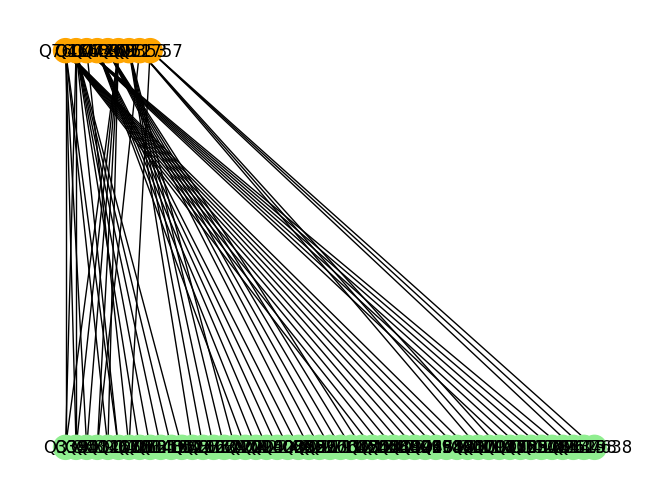

In [19]:
# Basic metrics on B
print(f'Nodes: {B.number_of_nodes()}  Edges: {B.number_of_edges()}  |U|={len(U)}  |V|={len(V)}')
print('Density:', graph_density(B))
print('Modularity (U vs V):', compute_modularity(B, [set(U), set(V)]))

# Alternate bipartite view (from Notebook 3)
draw_bipartite_graph(B, 'bipartite', True, True)


## 6) Scientist-side projection

Scientist projection |V|= 9 |E|= 5
Communities: 7
Modularity (projection): -0.2


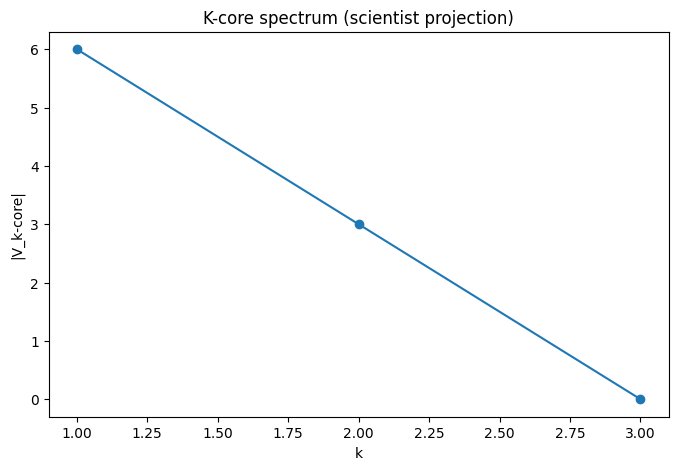

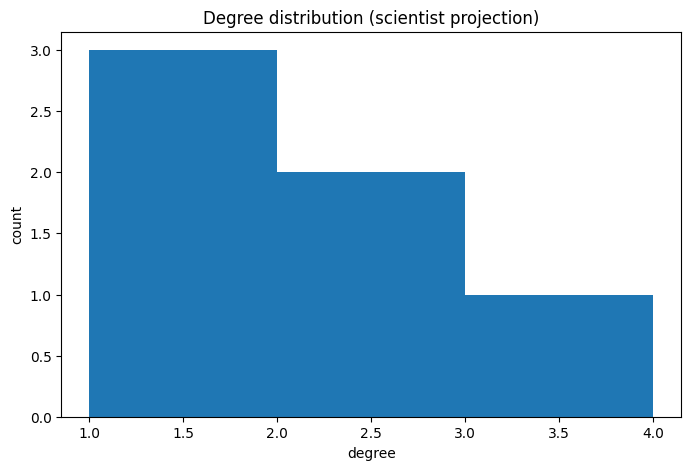

Graph entropy: 1.8910611120726528


In [20]:
Gs, Gf = project_bipartite_graph(B, 'bipartite')
print('Scientist projection |V|=', Gs.number_of_nodes(), '|E|=', Gs.number_of_edges())

# Communities + modularity
clusters = [set(c) for c in equivalence_classes(Gs, structurally_equivalent)]
print('Communities:', len(clusters))
print('Modularity (projection):', compute_modularity(Gs, clusters))

# k-core spectrum (simple loop)
ks, sizes = [], []
kmax = max(dict(Gs.degree()).values()) if Gs.number_of_nodes() else 0
for k in range(1, kmax+1):
    sub = k_core(Gs, k=k)
    n = sub.number_of_nodes() if hasattr(sub, 'number_of_nodes') else len(sub)
    ks.append(k); sizes.append(n)
if ks:
    plt.figure(figsize=(8,5))
    plt.plot(ks, sizes, marker='o')
    plt.title('K-core spectrum (scientist projection)')
    plt.xlabel('k'); plt.ylabel('|V_k-core|')
    plt.show()

# Degree histogram
deg = [d for _, d in Gs.degree()]
if deg:
    plt.figure(figsize=(8,5))
    plt.hist(deg, bins=range(1, max(deg)+2))
    plt.title('Degree distribution (scientist projection)')
    plt.xlabel('degree'); plt.ylabel('count')
    plt.show()

# Entropy
print('Graph entropy:', graph_entropy(Gs))


## 7) Field-side projection

We now project onto **fields** and run the same quick checks and plots.

Field projection |V|= 51 |E|= 207
Field communities: 51
Modularity (field projection): -0.026815094868024927


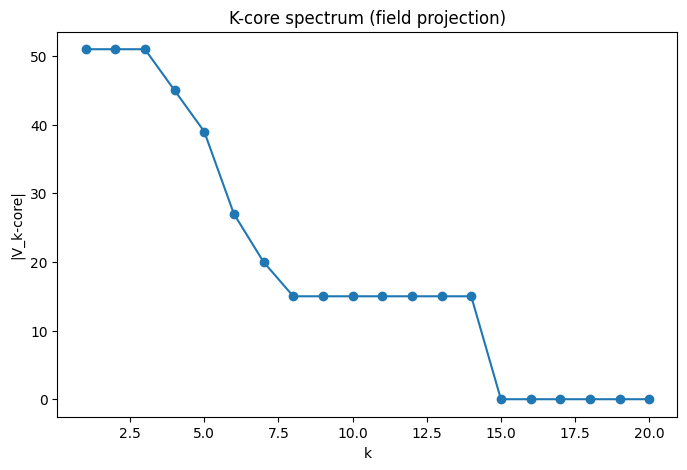

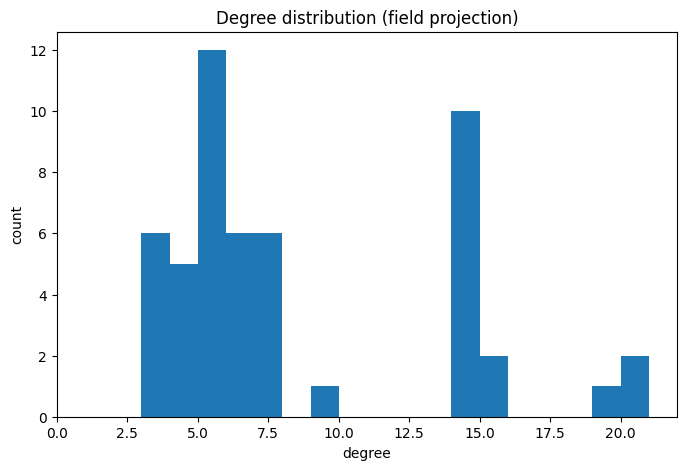

Graph entropy (fields): 2.959135215600023
Largest field clique sizes: [15, 8, 7, 6, 6]


In [21]:
Gs, Gf = project_bipartite_graph(B, 'bipartite')
print('Field projection |V|=', Gf.number_of_nodes(), '|E|=', Gf.number_of_edges())

# Communities + modularity on fields
clusters_f = [set(c) for c in equivalence_classes(Gf, structurally_equivalent)]
print('Field communities:', len(clusters_f))
print('Modularity (field projection):', compute_modularity(Gf, clusters_f))

# K-core spectrum (fields)
ks_f, sizes_f = [], []
kmax_f = max(dict(Gf.degree()).values()) if Gf.number_of_nodes() else 0
for k in range(1, kmax_f+1):
    sub = nx.k_core(Gf, k)
    ks_f.append(k); sizes_f.append(sub.number_of_nodes())
if ks_f:
    plt.figure(figsize=(8,5))
    plt.plot(ks_f, sizes_f, marker='o')
    plt.title('K-core spectrum (field projection)')
    plt.xlabel('k'); plt.ylabel('|V_k-core|')
    plt.show()

# Degree histogram (fields)
deg_f = [d for _, d in Gf.degree()]
if deg_f:
    plt.figure(figsize=(8,5))
    plt.hist(deg_f, bins=range(1, max(deg_f)+2))
    plt.title('Degree distribution (field projection)')
    plt.xlabel('degree'); plt.ylabel('count')
    plt.show()

# Entropy (fields)
print('Graph entropy (fields):', graph_entropy(Gf))

# Largest cliques (fields)
try:
    clqf = list(maximal_cliques(Gf))
    clqf.sort(key=len, reverse=True)
    print('Largest field clique sizes:', [len(c) for c in clqf[:5]])
except Exception:
    pass


## 7) Entropy under degree-preserving rewiring

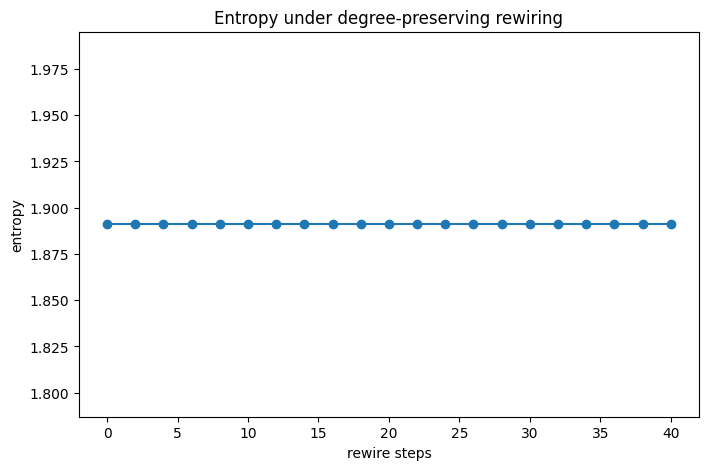

In [22]:
import copy
if 'Gs' not in locals():
    Gs, Gf = project_bipartite_graph(B, 'bipartite')
Gt = copy.deepcopy(Gs)
xs, ent = [0], [graph_entropy(Gt)]
for t in range(1, 41):
    Gt = rewire(Gt, 1)
    if t % 2 == 0:
        xs.append(t)
        ent.append(graph_entropy(Gt))
plt.figure(figsize=(8,5))
plt.plot(xs, ent, marker='o')
plt.title('Entropy under degree-preserving rewiring')
plt.xlabel('rewire steps'); plt.ylabel('entropy')
plt.show()


## 8) Quick summary

In [23]:
Gs, Gf = project_bipartite_graph(B, 'bipartite')
clusters_s = [set(c) for c in equivalence_classes(Gs, structurally_equivalent)]
clusters_f = [set(c) for c in equivalence_classes(Gf, structurally_equivalent)]
rows = []
rows.append({
    'graph': 'B (bipartite)',
    '|V|': B.number_of_nodes(),
    '|E|': B.number_of_edges(),
    'density': graph_density(B),
    'modularity': compute_modularity(B, [set(U), set(V)]),
    'entropy': graph_entropy(B)
})
rows.append({
    'graph': 'Scientists (projection)',
    '|V|': Gs.number_of_nodes(),
    '|E|': Gs.number_of_edges(),
    'density': graph_density(Gs),
    'modularity': compute_modularity(Gs, clusters_s),
    'entropy': graph_entropy(Gs)
})
rows.append({
    'graph': 'Fields (projection)',
    '|V|': Gf.number_of_nodes(),
    '|E|': Gf.number_of_edges(),
    'density': graph_density(Gf),
    'modularity': compute_modularity(Gf, clusters_f),
    'entropy': graph_entropy(Gf)
})
summary = pd.DataFrame(rows)
summary

,graph,|V|,|E|,density,modularity,entropy
0,B (bipartite),60,60,0.033898,-0.500000,1.576480
1,Scientists (projection),9,5,0.138889,-0.200000,1.891061
2,Fields (projection),51,207,0.162353,-0.026815,2.959135
